In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/test-images/t10k-images-idx3-ubyte
/kaggle/input/train-images/train-images-idx3-ubyte
/kaggle/input/train-labels/train-labels-idx1-ubyte
/kaggle/input/test-labels/t10k-labels-idx1-ubyte


# Option 1: Neural Network on Fashion MNIST

This notebook presents a complete implementation of a neural network using NumPy. The model is trained to classify images from the [Fashion MNIST](https://www.tensorflow.org/datasets/catalog/fashion_mnist) dataset, which contains grayscale images of 10 clothing categories such as T-shirts, trousers, dresses, and sneakers.

The model is a fully connected feedforward neural network (multi-layer perceptron) with two hidden layers using ReLU activation, softmax output, and mini-batch gradient descent. The notebook includes EDA, training progress visualization, model evaluation, and a discussion of parameter tuning.


In [3]:
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')  # Magic number
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        buf = f.read(rows * cols * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, rows, cols, 1)
        return data / 255.0

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')  # Magic number
        num_labels = int.from_bytes(f.read(4), 'big')
        buf = f.read(num_labels)
        labels = np.frombuffer(buf, dtype=np.uint8)
        return labels


In [4]:
X_train = load_mnist_images('/kaggle/input/train-images/train-images-idx3-ubyte')
y_train = load_mnist_labels('/kaggle/input/train-labels/train-labels-idx1-ubyte')
X_test = load_mnist_images('/kaggle/input/test-images/t10k-images-idx3-ubyte')
y_test = load_mnist_labels('/kaggle/input/test-labels/t10k-labels-idx1-ubyte')


In [5]:
# Class labels for Fashion MNIST
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

def show_sample_images(images, labels, class_names, num_samples=9):
    plt.figure(figsize=(7, 7))
    for i in range(num_samples):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


## 1. Exploratory Data Analysis (EDA)
Exploring the dataset shape and structure to understand the input size and class labels.

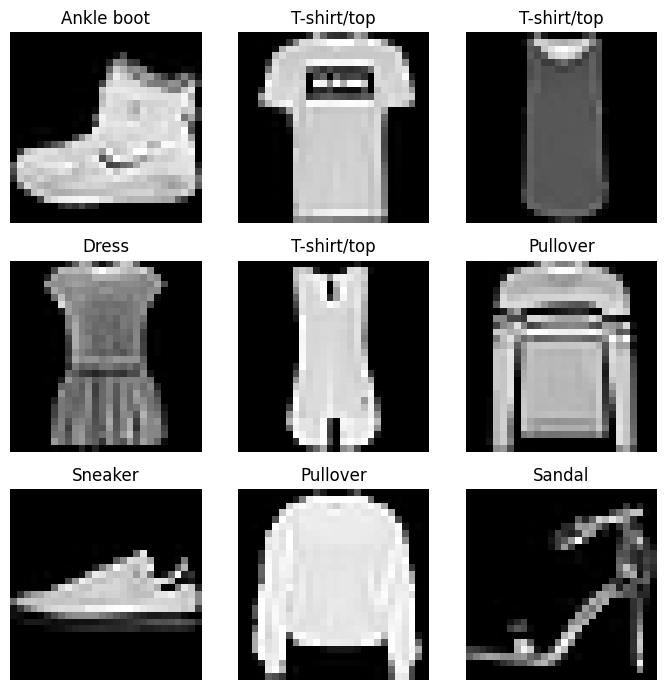

In [6]:
show_sample_images(X_train, y_train, class_names)

In [7]:
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Unique labels:", np.unique(y_train))

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


In [8]:
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

y_train_oh = one_hot_encode(y_train)
y_test_oh = one_hot_encode(y_test)

In [9]:
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Unique labels:", np.unique(y_train))

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


## 2. One-Hot Encoding and Flattening the Data
Converting categorical class labels into one-hot encoded vectors to be compatible with the softmax output layer.Images are reshaped from 28x28 matrices into 784-dimensional vectors for input into a fully connected network.

In [10]:
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

y_train_oh = one_hot_encode(y_train)
y_test_oh = one_hot_encode(y_test)

In [11]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # shape: (60000, 784)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


## 4. Weight Initialization
Weights and biases for each layer are initialized using He initialization to support ReLU activation. We also define ReLU, softmax, and cross-entropy loss functions along with their derivatives. Functions for forward pass and backpropagation using gradient descent are implemented.

In [12]:
# Initialize model parameters
def initialize_weights(input_size, hidden1_size, hidden2_size, output_size):
    W1 = np.random.randn(input_size, hidden1_size) * np.sqrt(2. / input_size)
    b1 = np.zeros((1, hidden1_size))
    W2 = np.random.randn(hidden1_size, hidden2_size) * np.sqrt(2. / hidden1_size)
    b2 = np.zeros((1, hidden2_size))
    W3 = np.random.randn(hidden2_size, output_size) * np.sqrt(2. / hidden2_size)
    b3 = np.zeros((1, output_size))
    return W1, b1, W2, b2, W3, b3

#  Activation functions and derivatives
def relu(x):
    return np.where(x > 0, x, 0.01 * x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0.01)
    
def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / np.sum(expZ, axis=1, keepdims=True)

# Loss function: Cross-entropy
def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    log_likelihood = -np.log(y_pred[range(m), np.argmax(y_true, axis=1)] + 1e-9)
    return np.sum(log_likelihood) / m

# Forward pass
def forward_pass(X, W1, b1, W2, b2, W3, b3):
    Z1 = X @ W1 + b1
    A1 = relu(Z1)
    Z2 = A1 @ W2 + b2
    A2 = relu(Z2)
    Z3 = A2 @ W3 + b3
    A3 = softmax(Z3)
    cache = (Z1, A1, Z2, A2, Z3, A3)
    return A3, cache

# Backward pass
def backward_pass(X, y, W2, W3, cache):
    Z1, A1, Z2, A2, Z3, A3 = cache
    m = y.shape[0]

    dZ3 = A3 - y
    dW3 = A2.T @ dZ3 / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m

    dA2 = dZ3 @ W3.T
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = A1.T @ dZ2 / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = X.T @ dZ1 / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    return dW1, db1, dW2, db2, dW3, db3

# Training loop
def train_model(X, y, X_val, y_val, hidden1_size=128, hidden2_size=64, learning_rate=0.05, epochs=50, batch_size=64):
    input_size = X.shape[1]
    output_size = y.shape[1]

    W1, b1, W2, b2, W3, b3 = initialize_weights(input_size, hidden1_size, hidden2_size, output_size)
    train_losses, val_accuracies = [], []

    for epoch in range(epochs):
        X, y = shuffle(X, y)

        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            y_pred, cache = forward_pass(X_batch, W1, b1, W2, b2, W3, b3)
            dW1, db1, dW2, db2, dW3, db3 = backward_pass(X_batch, y_batch, W2, W3, cache)

            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2
            b2 -= learning_rate * db2
            W3 -= learning_rate * dW3
            b3 -= learning_rate * db3

        # Evaluate full dataset after each epoch
        y_pred, _ = forward_pass(X, W1, b1, W2, b2, W3, b3)
        loss = compute_loss(y, y_pred)

        val_pred_probs, _ = forward_pass(X_val, W1, b1, W2, b2, W3, b3)
        val_preds = np.argmax(val_pred_probs, axis=1)
        val_labels = np.argmax(y_val, axis=1)
        accuracy = accuracy_score(val_labels, val_preds)

        train_losses.append(loss)
        val_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Val Acc: {accuracy:.4f}")

    return W1, b1, W2, b2, W3, b3, train_losses, val_accuracies

We train the model using mini-batch gradient descent, shuffling the data and tracking validation performance.

## Parameter Tuning and Optimization

Throughout training, several key hyperparameters were tested and adjusted to improve performance and training stability:

- **Learning Rate**:
  - Initially set to **0.1**, which led to rapid learning but occasional instability and sharp loss fluctuations.
  - Lowering the learning rate to **0.01** resulted in slower and less effective learning.
  - An intermediate value of **0.05** provided the best tradeoff, producing a steady learning curve and high accuracy (~88.7%).


- **Mini-Batch Size**:
  - A batch size of **64** was used during training to balance memory usage and training stability.

- **Model Depth**:
  - The architecture was adjusted from a single hidden layer to **two hidden layers** (128 and 64 neurons respectively), which improved the network’s ability to learn more complex features.



In [13]:
# Train the model
W1, b1, W2, b2, W3, b3, losses, accuracies = train_model(X_train_flat, y_train_oh, X_test_flat, y_test_oh)


Epoch 1/50 - Loss: 0.5356 - Val Acc: 0.7899
Epoch 2/50 - Loss: 0.4197 - Val Acc: 0.8320
Epoch 3/50 - Loss: 0.3495 - Val Acc: 0.8585
Epoch 4/50 - Loss: 0.3963 - Val Acc: 0.8338
Epoch 5/50 - Loss: 0.3606 - Val Acc: 0.8471
Epoch 6/50 - Loss: 0.3347 - Val Acc: 0.8567
Epoch 7/50 - Loss: 0.3227 - Val Acc: 0.8576
Epoch 8/50 - Loss: 0.3329 - Val Acc: 0.8537
Epoch 9/50 - Loss: 0.2847 - Val Acc: 0.8731
Epoch 10/50 - Loss: 0.2917 - Val Acc: 0.8664
Epoch 11/50 - Loss: 0.2665 - Val Acc: 0.8768
Epoch 12/50 - Loss: 0.2653 - Val Acc: 0.8775
Epoch 13/50 - Loss: 0.2796 - Val Acc: 0.8663
Epoch 14/50 - Loss: 0.2534 - Val Acc: 0.8794
Epoch 15/50 - Loss: 0.2607 - Val Acc: 0.8734
Epoch 16/50 - Loss: 0.2714 - Val Acc: 0.8635
Epoch 17/50 - Loss: 0.2687 - Val Acc: 0.8693
Epoch 18/50 - Loss: 0.2189 - Val Acc: 0.8836
Epoch 19/50 - Loss: 0.2163 - Val Acc: 0.8812
Epoch 20/50 - Loss: 0.2288 - Val Acc: 0.8781
Epoch 21/50 - Loss: 0.2137 - Val Acc: 0.8819
Epoch 22/50 - Loss: 0.2164 - Val Acc: 0.8812
Epoch 23/50 - Loss:

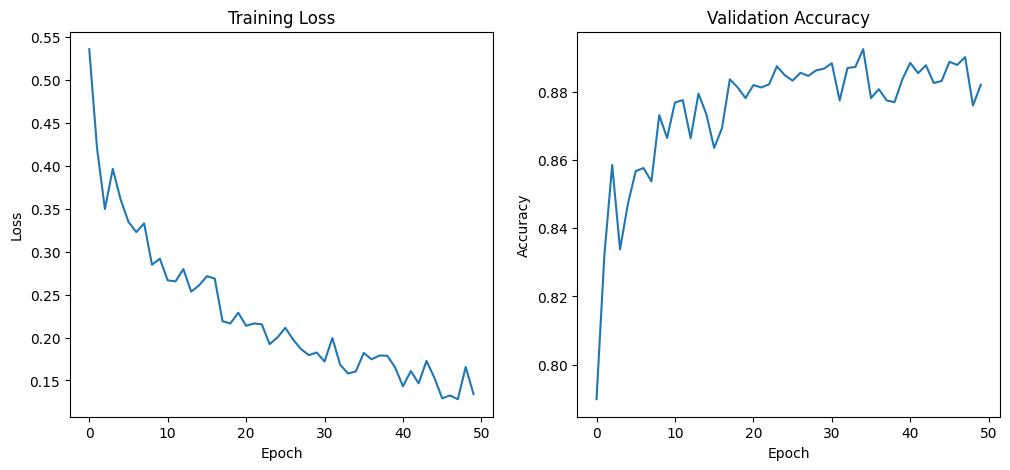

Final Test Accuracy: 0.882
Confusion Matrix:
 [[833   0  18  23   5   0 112   0   9   0]
 [  4 967   4  16   6   0   2   0   0   1]
 [ 12   0 793   7  75   0 111   0   2   0]
 [ 23   4  23 859  43   0  45   0   3   0]
 [  0   1 126  20 760   0  93   0   0   0]
 [  0   0   1   1   0 949   0  28   1  20]
 [101   0  57  25  40   0 775   0   2   0]
 [  0   0   0   0   0  12   0 973   0  15]
 [  5   1   3   4   1   2  13   6 965   0]
 [  1   0   0   0   0   3   1  49   0 946]]


In [14]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Final evaluation
final_preds = np.argmax(forward_pass(X_test_flat, W1, b1, W2, b2, W3, b3)[0], axis=1)
print("Final Test Accuracy:", accuracy_score(y_test, final_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_preds))

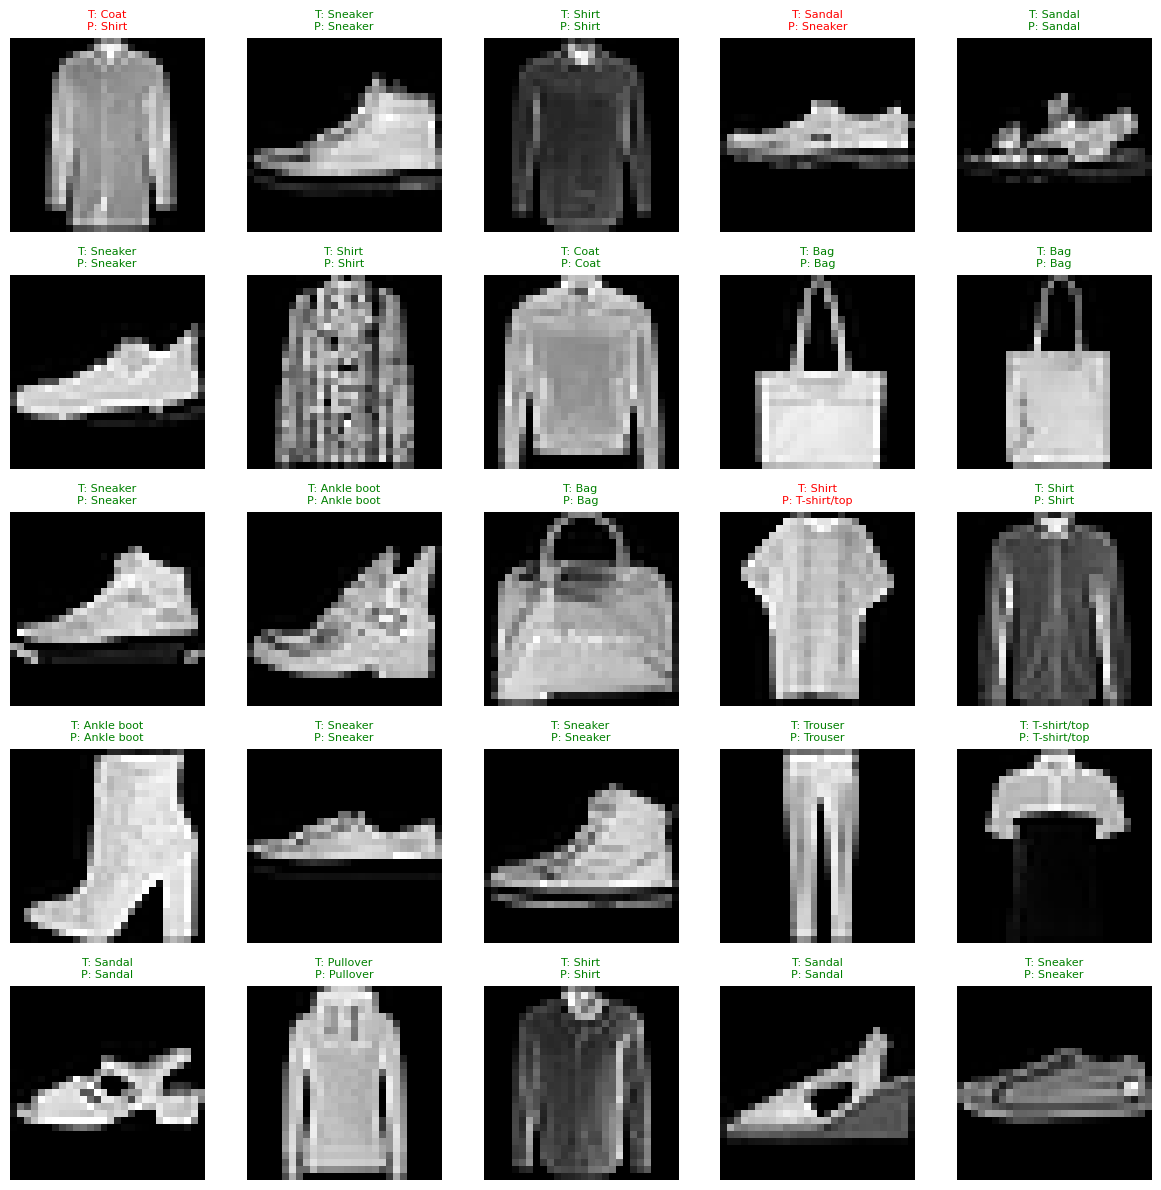

In [15]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

predictions = np.argmax(forward_pass(X_test_flat, W1, b1, W2, b2, W3, b3)[0], axis=1)
true_labels = y_test


plt.figure(figsize=(12, 12))
for i in range(25):
    idx = np.random.randint(0, len(X_test))
    img = X_test[idx].reshape(28, 28)
    true_label = class_names[true_labels[idx]]
    pred_label = class_names[predictions[idx]]
    
    color = 'green' if true_label == pred_label else 'red'
    
    plt.subplot(5, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"T: {true_label}\nP: {pred_label}", color=color, fontsize=8)
    
plt.tight_layout()
plt.show()
